<a href="https://colab.research.google.com/github/davidfox87/neuro_encoding_models/blob/master/fitting_temporal_filter_models_to_behavior_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis and prediction using a machine learning approach
__Content creator:__ David Fox

In [ ]:
#@title Clone the github repository 
!git clone https://github.com/davidfox87/neuro_encoding_models

Cloning into 'neuro_encoding_models'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (84/84), done.
remote: Total 545 (delta 69), reused 74 (delta 45), pack-reused 416
Receiving objects: 100% (545/545), 11.55 MiB | 34.09 MiB/s, done.
Resolving deltas: 100% (298/298), done.


In [ ]:
%cd neuro_encoding_models/

/content/neuro_encoding_models


In [ ]:
#@title add package to google colab
import sys, os
sys.path.append(os.getcwd())

In [ ]:
#@title import modules
import utils.read as io
import numpy as np
from matplotlib import pyplot as plt
from glmtools.make_xdsgn import Experiment, DesignSpec
from basisFactory.bases import Basis, RaisedCosine
from scipy.optimize import minimize
from glmtools.fit import x_proj, fit_nlin_hist1d, normalize
from utils import plot as nmaplt
import pickle
from numpy import linalg as LA
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

In [123]:
#@title helper functions
def make_bases(dur, peaks, stim_nbases, stretch, dt=0.02):
	fs = 1. / dt
	first_peak, last_peak = peaks
	
	nkt = int(dur * fs) # length of filter in number of samples
	# stim_nbases = number of vectors that are raised cosines
	stim_basis = RaisedCosine(100, stim_nbases, 1, 'stim')
 
	# arguments for makeNonlinearRaisedCosStim are 
	# dt sample interval
	# peaks = [position of first center, position of last center], 
	# stretch = spacing of basis centers (higher value = more linear meaning spread out,
	# lower value = nonlinear more centers near 0)
	# nkt = length of filter. If length of filters exceeds nkt we trim the filters, 
	# otherwise we pad with 0's
	# stim_basis.makeNonlinearRaisedCosStim(.1, [10, round(nkt/1.7)], stretch, nkt)  # first and last peak positions,
	stim_basis.makeNonlinearRaisedCosStim(.1, [first_peak / dt, last_peak / dt], stretch, nkt)
	return stim_basis


def make_dspec(stim, response, dt):
	# make an Experiment object
	expt = Experiment(dt, len(stim)*dt, stim=stim, response=response)

	# register continuous regressor
	expt.registerContinuous('stim')

	# initialize design spec with one trial
	return DesignSpec(expt, [0])
 



 

In [ ]:
#@title graph properties
plt.rc('lines', linewidth=2, color='red')
font = {'family' : 'arial',
        'size'   : 20}
plt.rc('font', **font)

Objectives: We will use ridge regression  to forecast the response of flies during dynamic odor presentations. Ridge regularization is used to find a temporal filter that generalizes to all parts of the response and thus avoids overfitting. We use the model to predict the behavior and to evaluate the performances of the model on held-out data.

# 1. Load the data and plot the stimulus and response


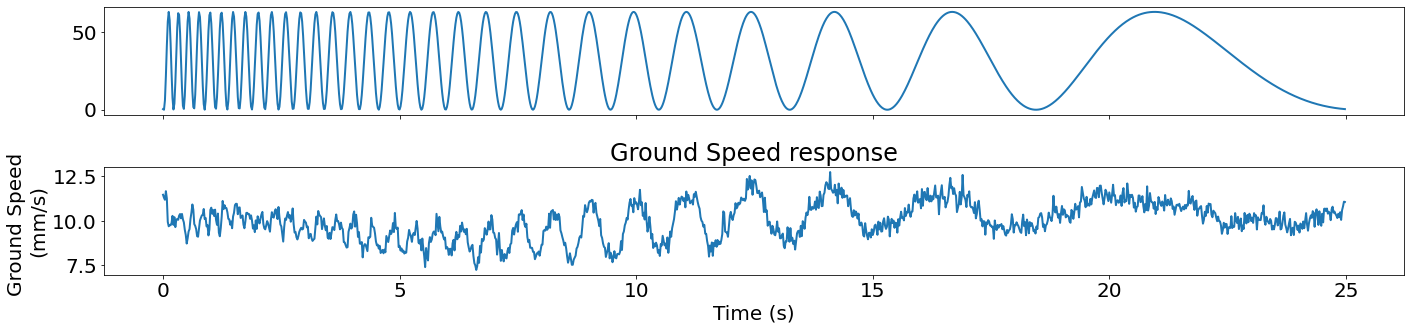

In [124]:
behavior_par = "vmoves"
#behavior_par = "angvturns"
#behavior_par = "vymoves"
# load behavior from MATLAB .mat file
stim, response = io.load_behavior('datasets/behavior/control_behavior.mat', 30., 55., behavior_par, 50)
response = response.mean(axis=1)
stim = stim[:, 0]

fs = 50
t = np.arange(len(stim)) / fs
stim = stim.reshape((len(stim), 1))
response = response.reshape((len(stim), 1))
fig, ax = plt.subplots(2, 1, sharex=True, figsize=[20, 5])
ax[0].plot(t, stim)
ax[1].plot(t, response)
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Ground Speed \n(mm/s)')
ax[1].set_title('Olfactory Stimulus')
ax[1].set_title('Ground Speed response')
plt.tight_layout()

# Data preparation
Now that we know how to load the data, we can separate into train and test datasets. We can split the time series into the first 18 s of movement for training and the last 7 s of movement for testing.

In [125]:
# split into train and test
stim_train, stim_test, resp_train, resp_test = train_test_split(stim, response,
                                test_size=0.1,
                                shuffle=False,
                                random_state=42)
dt = 0.02
# make train dspec
train_dspec = make_dspec(stim_train, resp_train, dt)
# make test dspec
test_dspec = make_dspec(stim_test, resp_test, dt)

# Make a smooth temporal basis to represent temporal filter

The ultimate output of the regression is a set of filter weights that define a stimulus temporal filter. We already have an idea about how such temporal filters should look. Briefly, events that happened closer in time to the response should be weighted highly than events further back in time. Temporal filters often have structure at both short- and long time scales and we can use a express our stimulus in terms of weights in a simple basis.

Here we build low-dimensional space spanned by raised cosines. This is called our filter bank and we will use this to transform our stimulus.  

# Make a collection of basis vectors
Specify the following argments to the `make_bases` function:

1.   duration of filter 
2.   position of filter centers [first peak time, last peak time]
3.   center stretch parameter
4.   Number of basis vectors

See example below



Text(0.5, 1.0, 'Raised Cosine basis')

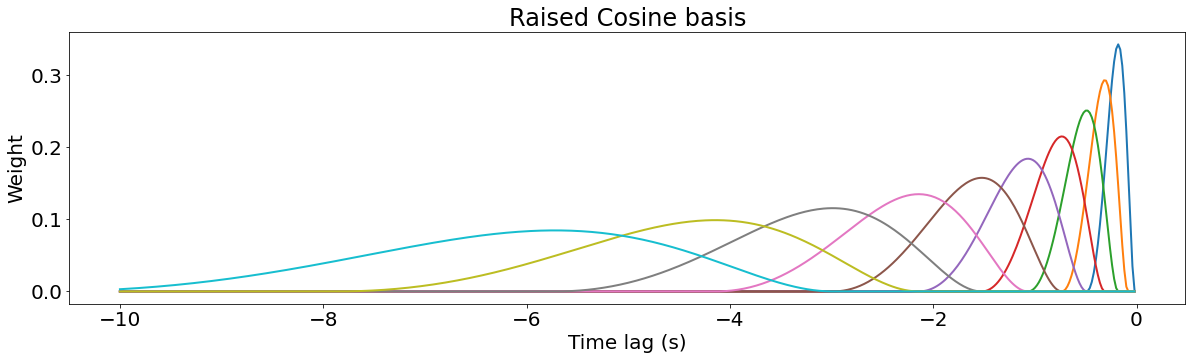

In [137]:
stim_basis = make_bases(10., [0.16, 5.7], 10, 10) 
t = np.arange(-len(stim_basis.B), 0) * dt

fig, ax = plt.subplots(1, 1, figsize=[20, 5])
ax.plot(t, stim_basis.B);
ax.set_xlabel('Time lag (s)')
ax.set_ylabel('Weight')
ax.set_title('Raised Cosine basis')

In [ ]:
train_dspec.addRegressorContinuous(basis=cos_basis)
test_dspec.addRegressorContinuous(basis=cos_basis)

# create the design matrices for train and test


100%|██████████| 1/1 [00:00<00:00, 224.85it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: set_ticks() must have been called.


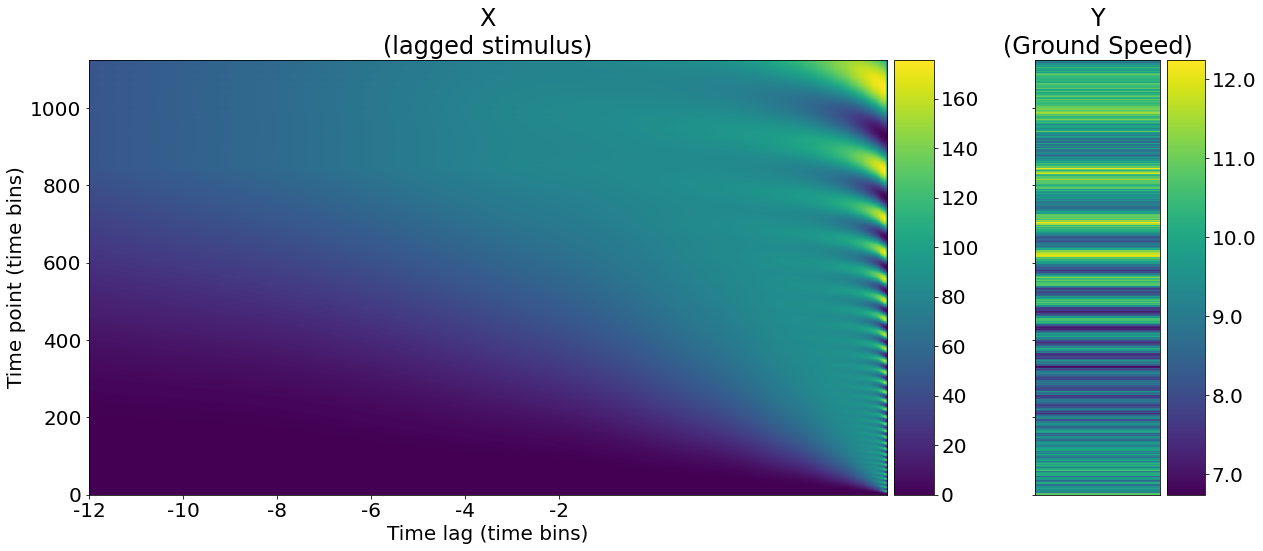

In [ ]:
# compile a design matrix using all trials
dm, X_train, y_train = train_dspec.compileDesignMatrixFromTrialIndices(bias=1)
dm, X_test, y_test = train_dspec.compileDesignMatrixFromTrialIndices(bias=1)

from mpl_toolkits.axes_grid1 import make_axes_locatable

# this is our design matrix
f, (ax_x, ax_y) = plt.subplots(
    ncols=2,
    figsize=(20, 8),
    sharey=True,
    gridspec_kw=dict(width_ratios=(5, 1)),
  )

imx = ax_x.imshow(X_train[:, 1:] @ cos_basis.B.T,
            interpolation='nearest', aspect='auto')
imy = ax_y.pcolormesh(y_train.reshape(-1, 1))
ax_y.invert_yaxis()

ax_y.set(
    title="Y\n(Ground Speed)",
    xticks=[]
  )

plt.setp(ax_y.spines.values(), visible=True)


ax_x.set(
    title="X\n(lagged stimulus)",
    xlabel="Time lag (time bins)",
    xticks=[0, 100, 200, 300, 400, 500],
    xticklabels=['-12', '-10', '-8', '-6', '-4', '-2'],
    ylabel="Time point (time bins)",
  )
plt.setp(ax_x.spines.values(), visible=True)

divy = make_axes_locatable(ax_y)
caxy = divy.append_axes("right", size="30%", pad=0.1)
cbary = f.colorbar(imy, cax=caxy)
cbary.set_ticks(np.arange(y_train.max()) + .5)
cbary.set_ticklabels(np.arange(y_train.max()))

divx = make_axes_locatable(ax_x)
caxx = divx.append_axes("right", size="5%", pad=0.1)
cbarx = f.colorbar(imx, cax=caxx)
cbarx.set_ticklabels(np.sort(np.unique(stim_train)))

# Now perform cross-validation to find the ridge penalty that gives the best average mse across validation folds

In [ ]:
model = Ridge()
alphas = np.logspace(0, 30, num=20, base=2)
param_search = [{'alpha': alphas}]

tscv = TimeSeriesSplit(n_splits=5)
grid_result = GridSearchCV(estimator=model, cv=tscv,
                param_grid=param_search, scoring='neg_mean_squared_error', n_jobs=-1)

grid_result.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# using this ridge penalty value, get the mse between resp_test and ridge prediction
model = Ridge(alpha=grid_result.best_params_['alpha']).fit(X_test, y_test)
w = model.coef_

d = dm.get_regressor_from_output(w)

# convert back to the original basis to get nkt filter weights.
# Parameters are returned in a dict
dc = w[0]
k = d['stim'][1]
kt = d['stim'][0] * dt

xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim_test, resp_test, k, dt, 20)
basis_score = r2_score(resp_test, fnlin(rawfilteroutput))
basis_mse = mean_squared_error(resp_test, fnlin(rawfilteroutput))

print('The r2 on the held-out test set is {}'.format(basis_score))
print('The mse on the held-out test set is {}'.format(basis_mse))


Best: -0.447474 using {'alpha': 56637.64599810335}
The r2 on the held-out test set is 0.20825139134110993
The mse on the held-out test set is 0.1308492333327151


# Ridge regression and CV

In [ ]:
# now fit using this ridge on all the data
dspec = make_dspec(stim, response, dt)
dspec.addRegressorContinuous(basis=cos_basis)

# compile a design matrix using all trials
dm, X_, y_ = dspec.compileDesignMatrixFromTrialIndices(bias=1)
model = Ridge(alpha=grid_result.best_params_['alpha']).fit(X_, y_)

w = model.coef_

d = dm.get_regressor_from_output(w)

100%|██████████| 1/1 [00:00<00:00, 197.17it/s]


Text(0.5, 1.0, 'Stimulus temporal filter for ground speed')

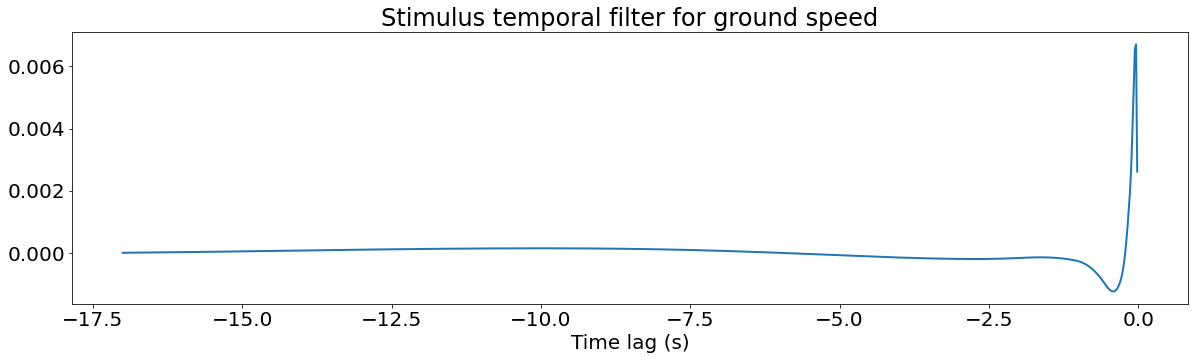

In [ ]:
# convert back to the original basis to get nkt filter weights.
# Parameters are returned in a dict
dc = w[0]
k = d['stim'][1]
kt = d['stim'][0] * dt

plt.figure(figsize=[20, 5])
plt.plot(kt, k)
plt.xlabel('Time lag (s)')
plt.title('Stimulus temporal filter for ground speed')

# Lets see how well this model describes the data

In [ ]:
fs = 50
stim_ = stim[:, 0]
response_ = np.reshape(response, (25*fs, -1)).mean(axis=1)

xx, fnlin, rawfilteroutput = fit_nlin_hist1d(stim_, response_, k, dt, 20)


The r2 on the held-out test set is 0.20825139134110993
The mse on the held-out test set is 0.18395530103061206


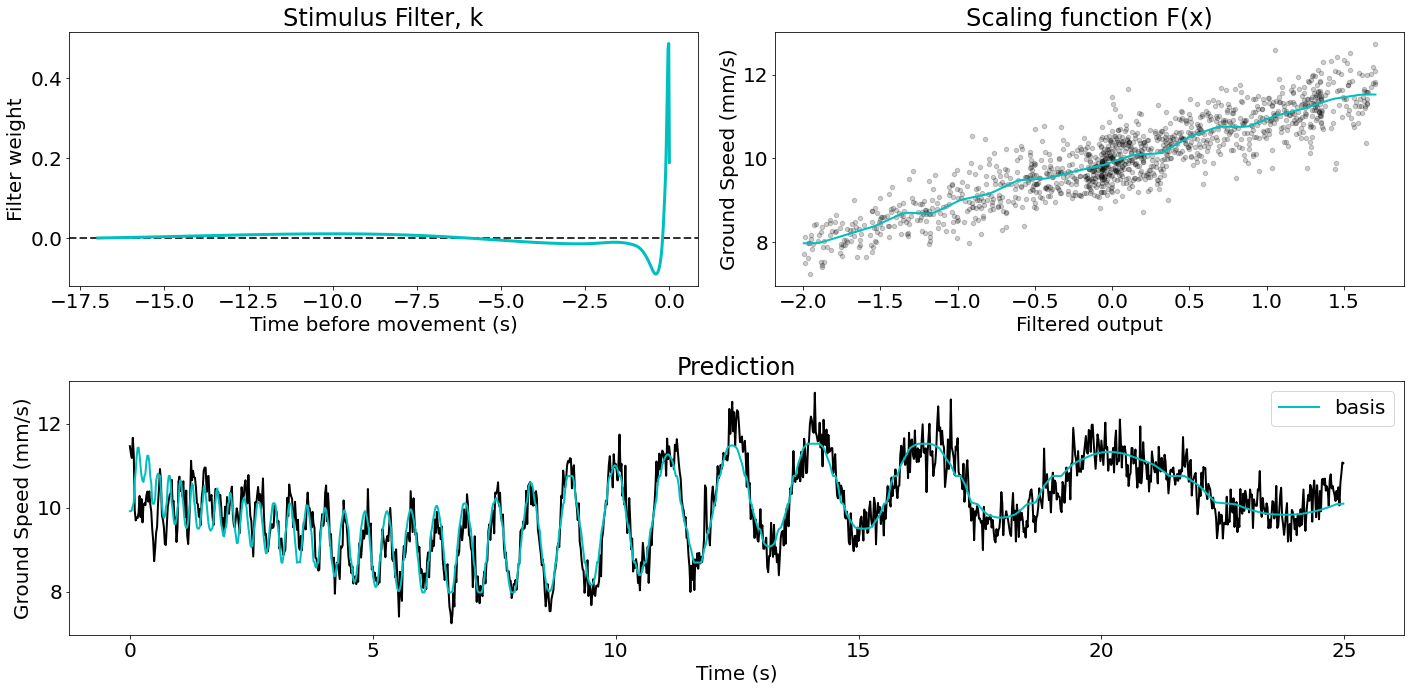

In [ ]:
fig = plt.figure(figsize=[20, 10])
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(212)

nmaplt.plot_spike_filter(ax1, k/LA.norm(k), dt, linewidth=3, color='c', label="basis")
# ax1.set_xlim(-5, 0)
ax1.set_xlabel('Time before movement (s)')
ax2.scatter(rawfilteroutput, response_, s=20, c='k', alpha=0.2)
ax2.plot(xx, fnlin(xx), 'c', linewidth=2)

t = np.arange(0, 25 * fs) / fs
ax3.plot(t, response_, 'k', linewidth=2)
ax3.plot(t, fnlin(rawfilteroutput), 'c', linewidth=2, label="basis")

ax3.set_ylabel('Ground Speed (mm/s)')
ax3.set_xlabel('Time (s)')
ax2.set_xlabel('Filtered output')
ax2.set_ylabel('Ground Speed (mm/s)')
ax2.set_title('Scaling function F(x)')

ax1.set_title('Stimulus Filter, k')

ax3.set_title("Prediction")
ax3.legend()

ridge_score = r2_score(response_, fnlin(rawfilteroutput))
basis_mse = mean_squared_error(response_, fnlin(rawfilteroutput))

print('The r2 on the held-out test set is {}'.format(basis_score))
print('The mse on the held-out test set is {}'.format(basis_mse))

plt.tight_layout()
plt.show()